High-level idea: we want to approximate the data distribution $P(X)$. This is
hard. We posit simpler latent structure, conditioned on which the structure of
the data is easier to work with.

$$
p(X) = \int_{\mathcal{Z}} dZ p(X \mid Z) p(Z)
$$

We can use a complicated function approximator to map samples $Z$ to
distributions on the data space:

$$
p(X \mid Z) = p\left(X \mid f\left(Z; \theta\right)\right)
$$

where $f$ is some sufficiently expressive function from the latent space into the
space of *parameters* of the distribution family of $p(X \mid Z)$. Given this
setup, we might approximate $p(X)$ via Monte Carlo, by sampling from the prior
$p(Z)$ and averaging. Note that we suppose we have $N$ data samples, IID given
the latent structure, so the above integral actually looks like

$$
p(X_!, \ldots, X_N) =
    \int dZ \prod_i p(X_i \mid Z) p(Z)
$$

So our Monte Carlo sampling scheme should look like (moving to log space):

$$
\log p(X_1, \ldots, X_N) =
    \frac{1}{S} \sum_{i=1}^N \sum_{s=1}^S p(X_i \mid f(Z_s; \theta))
$$

where $Z_s \sim p(Z)$.

Now the problem is that sampling from $p(Z)$ is going to give poor estimates of
the integral, since early in learning $f$, prior samples of $Z$ are unlikely to
map through $f$ to areas of high density in the data space. The trick, then,
will be to use another complicated mapping $g$ to map the data $X$ to
distributions on the latent space, such that sampling from these distributions
leads us, through $f$, to areas of higher density in data space. Let's try some
coding.

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd
from tensorflow_probability import bijectors as tfb
import warnings
warnings.filterwarnings('ignore')
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
(x_train, _), _ = tf.keras.datasets.mnist.load_data()
x_train = x_train[..., np.newaxis]
x_train = x_train.astype(np.float32) / 256.
print(x_train.dtype, x_train.shape, x_train.min(), x_train.max())

float32 (60000, 28, 28, 1) 0.0 0.99609375


Step 0, loss = 543.397888
Step 1000, loss = 161.020660
Step 2000, loss = 150.434570
Step 3000, loss = 160.521347
Step 3999, loss = 162.040619


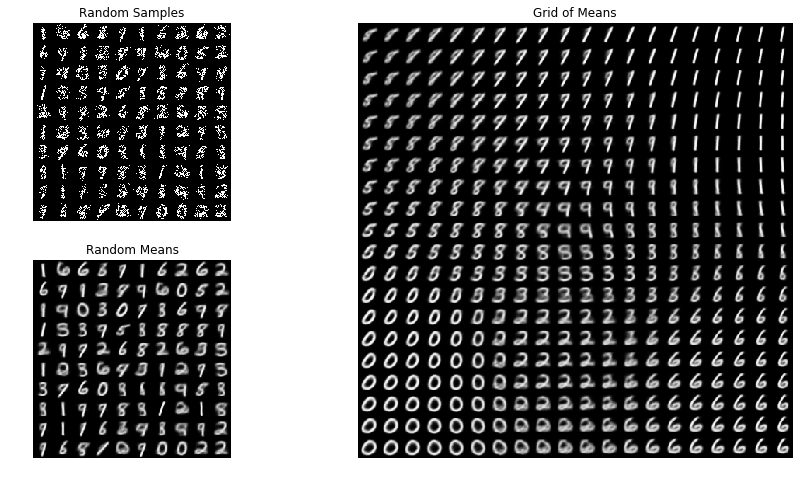

In [4]:
def _(sess):
  BATCH_SIZE = 32
  N_SAMPLES = 16
  LATENT_SIZE = 2
  ACTIVATION = tf.nn.leaky_relu
  OUTPUT_SHAPE = [28, 28, 1]
  NUM_ITERS = 4000
  EVAL_INTERVAL = 1000

  # The encoder and decoder architectures were inspired by the TensorFlow
  # Probability VAE example code. I tried my own DNN thing and it did realllly
  # badly. The TF example can be found here:
  # https://github.com/tensorflow/probability/blob/master/tensorflow_probability/examples/vae.py
  def make_encoder():
    encoder_net = tf.keras.Sequential([
      tf.keras.layers.Conv2D(32, 5, 1, padding="SAME", activation=ACTIVATION),
      tf.keras.layers.Conv2D(32, 5, 2, padding="SAME", activation=ACTIVATION),
      tf.keras.layers.Conv2D(64, 5, 1, padding="SAME", activation=ACTIVATION),
      tf.keras.layers.Conv2D(64, 5, 2, padding="SAME", activation=ACTIVATION),
      tf.keras.layers.Conv2D(128, 7, padding="VALID", activation=ACTIVATION),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(2 * LATENT_SIZE, activation=None),
    ])

    def encoder(x):
      x = 2 * x - 1
      y = encoder_net(x)
      loc = y[..., :LATENT_SIZE]
      scale = tf.nn.softplus(y[..., LATENT_SIZE:] + 0.235)
      return tfd.Independent(
        tfd.Normal(loc, scale),
        reinterpreted_batch_ndims=1)
    return encoder

  def make_decoder():
    decoder_net = tf.keras.Sequential([
      tf.keras.layers.Conv2DTranspose(64, 7, padding="VALID", activation=ACTIVATION),
      tf.keras.layers.Conv2DTranspose(64, 5, padding="SAME", activation=ACTIVATION),
      tf.keras.layers.Conv2DTranspose(64, 5, 2, padding="SAME", activation=ACTIVATION),
      tf.keras.layers.Conv2DTranspose(32, 5, padding="SAME", activation=ACTIVATION),
      tf.keras.layers.Conv2DTranspose(32, 5, 2, padding="SAME", activation=ACTIVATION),
      tf.keras.layers.Conv2DTranspose(32, 5, padding="SAME", activation=ACTIVATION),
      tf.keras.layers.Conv2D(1, 5, padding="SAME", activation=None),
    ])

    def decoder(z):
      orig_shape = tf.shape(z)
      z = tf.reshape(z, (-1, 1, 1, LATENT_SIZE))
      logits = decoder_net(z)
      logits = tf.reshape(logits,
                          tf.concat([orig_shape[:-1], OUTPUT_SHAPE], axis=0))
      return tfd.Independent(tfd.Bernoulli(logits=logits),
                             reinterpreted_batch_ndims=len(OUTPUT_SHAPE))
    return decoder

  prior_rv = tfd.Independent(
    tfd.Normal(np.zeros(LATENT_SIZE, np.float32), 1.),
    reinterpreted_batch_ndims=1)
  # We want to maximize the lower bound on the evidence p(X):
  #
  #  p(x) <= E_data[E_q(z|x)[log p(x | z) - KL(q, p(z))]]
  #                          `---------'    `----------'
  #                               |              `-- regularization term (neg. reinf.)
  #                               `--- reconstruction term (pos. reinf.)
  data = tf.placeholder(np.float32, [None] + OUTPUT_SHAPE, 'x')

  encoder = make_encoder()
  encoder_rv = encoder(data)
  # ==> A (batch of) Normal distribution(s), parameterized by NN outputs
  #     at the data inputs.

  z_samples = encoder_rv.sample(N_SAMPLES)
  # ==> `encoder_rv` is a batch of N distributions, where N is the size of
  #     `data`. Thus, a single "sample" is actually a batch of N independent
  #     samples, and `N_SAMPLES` samples is a collection of samples with
  #     shape [N_SAMPLES, N] where `N_SAMPLES` samples are drawn IID from
  #     each of a batch of `N` *distinct* (non-identical) distributions.

  decoder = make_decoder()
  decoder_rv = decoder(z_samples)

  likelihood = decoder_rv.log_prob(data)
  kl = tfd.kl_divergence(encoder_rv, prior_rv)

  loss = -tf.reduce_mean(likelihood - kl)
  train_op = tf.train.AdamOptimizer().minimize(loss)

  z_prior_samples = prior_rv.sample((10, 10))
  data_samples_rv = decoder(z_prior_samples)
  data_samples = data_samples_rv.sample()
  data_samples_means = data_samples_rv.mean()
  grid_samples_rv = decoder(
    np.stack(np.meshgrid(np.linspace(-2., 2., 20),
                         np.linspace(-2., 2., 20)), axis=-1).astype(np.float32))
  grid_samples_means = grid_samples_rv.mean()

  sess.run(tf.global_variables_initializer())
  for i in range(NUM_ITERS):
    batch_indices = np.random.randint(0, x_train.shape[0], size=(BATCH_SIZE))
    _, loss_ = sess.run([train_op, loss], {data: x_train[batch_indices, ...]})
    if i % EVAL_INTERVAL == 0 or i + 1 == NUM_ITERS:
      print("Step %d, loss = %f" % (i, loss_))
  [
    data_samples_,
    data_samples_means_,
    grid_samples_means_,
  ] = sess.run([
    data_samples,
    data_samples_means,
    grid_samples_means,
  ])

  image_tiles_ = 1. - np.transpose(
    np.squeeze(data_samples_), [0, 2, 1, 3]).reshape(280, 280)
  mean_image_tiles_ = 1. - np.transpose(
    np.squeeze(data_samples_means_), [0, 2, 1, 3]).reshape(280, 280)
  grid_image_tiles_ = 1. - np.transpose(
    np.squeeze(grid_samples_means_), [0, 2, 1, 3]).reshape(560, 560)

  plt.figure(figsize=(15, 8))
  ax = plt.subplot2grid((2, 3), (0, 0))
  ax.set_title('Random Samples')
  ax.imshow(image_tiles_, cmap=mpl.cm.Greys, interpolation='none')
  ax.axis('off')
  ax = plt.subplot2grid((2, 3), (1, 0))
  ax.set_title('Random Means')
  ax.imshow(mean_image_tiles_, cmap=mpl.cm.Greys, interpolation='none')
  ax.axis('off')
  ax = plt.subplot2grid((2, 3), (0, 1), rowspan=2, colspan=2)
  ax.set_title('Grid of Means')
  ax.imshow(grid_image_tiles_, cmap=mpl.cm.Greys, interpolation='none')
  ax.axis('off')
  plt.show()

with tf.Graph().as_default(), tf.Session() as sess:
  _(sess)